# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

# Design DL Model

In [7]:
# Reading data with original 69 Features
train_data = pd.read_csv("Data/train_data.csv", compression = "bz2")
test_data = pd.read_csv("Data/test_data.csv", compression = "bz2")

# Reading questions-based features
train_vectors = pd.read_pickle("train_vectors.pkl", compression = "bz2")
test_vectors = pd.read_pickle("test_vectors.pkl", compression = "bz2")

In [8]:
print("Number of rows in train data =", train_data.shape[0])
print("Number of columns in train data =", train_data.shape[1])

Number of rows in train data = 323443
Number of columns in train data = 69


In [9]:
print("Number of rows in test data =", test_data.shape[0])
print("Number of columns in test data =", test_data.shape[1])

Number of rows in test data = 80868
Number of columns in test data = 69


In [10]:
print("Number of rows in train vectors =", train_vectors.shape[0])
print("Number of columns in train vectors =", train_vectors.shape[1])

Number of rows in train vectors = 323443
Number of columns in train vectors = 300


In [11]:
print("Number of rows in train vectors =", test_vectors.shape[0])
print("Number of columns in train vectors =", test_vectors.shape[1])

Number of rows in train vectors = 80868
Number of columns in train vectors = 300


Now we will choose the columns we need out of our original features space, it seem to say that the features i designed using log transformation caused some problem when applying log on zero or near-zero values, and that has impacted a wide range on data, so i choose to discard those feautres and drop them out of features space.

If we choose to let them, we have to modify log transformation we have applied on the data so we don't have to do log on zero values as in our first processing, and there is various way to fix this issues.

In [12]:
cols = ['question1_len', 'question2_len', 'question1_freq',
       'question2_freq', 'len_diff', 'question1_n_words', 'question2_n_words',
       'words_diff', 'words_common', 'words_share', 'frequency_sum',
       'frequency_diff', 'words_share_square',
       'words_common_square', 'cw_to_min_c', 'cw_to_max_c', 'cs_to_min_c',
       'cs_to_max_c', 'ct_to_min_c', 'ct_to_max_c', 'last_equal',
       'first_equal', 'tokens_diff', 'sequence_matcher',
       'levenshtein_distance', 'token_set_ratio', 'token_sort_ratio',
       'fuzzy_ratio', 'fuzzy_partial_ratio', 'lognest_substring_ratio',
       'ecludian_distance', 'ct_to_max_c_root', 'ct_to_max_c_sin',
       'ct_to_min_c_cos', 'ct_to_min_c_root','ct_to_min_c_sin', 'ct_to_min_c_square', 
        'cw_to_min_c_root','cw_to_min_c_cos', 'cw_to_max_c_root', 'cw_to_max_c_sin',
       'levenshtein_distance_root','levenshtein_distance_sin','lognest_substring_ratio_sin',
       'fuzzy_ratio_root', 'fuzzy_partial_ratio_root', 'token_sort_ratio_root',
       'token_sort_ratio_square', 'token_set_ratio_root',
       'sequence_matcher_cos', 'sequence_matcher_root',
       'sequence_matcher_sin', 'sequence_matcher_square',
       'sequence_matcher_cube', "is_duplicate"]
      
train_data = train_data[cols]
test_data = test_data[cols]

In [13]:
y_test = test_data[["is_duplicate"]]
y_train = train_data[["is_duplicate"]]

train_data.drop(["is_duplicate"], axis = 1, inplace = True)
test_data.drop(["is_duplicate"], axis = 1, inplace = True)

x_train = train_data
x_test = test_data

In [ ]:
print("Number of rows in x_train =", x_train.shape[0])
print("Number of columns in x_train =", x_train.shape[1])

Number of rows in x_train = 323443
Number of columns in x_train = 54


In [ ]:
print("Number of rows in x_test =", x_test.shape[0])
print("Number of columns in x_test =", x_test.shape[1])

Number of rows in x_test = 80868
Number of columns in x_test = 54


As i intended to use Neural Networks for modeling stage, then i have to apply some kind of scaling on data and it's really important stage for Neural Networks family of algorithms while tree algorithms don't need this stage, so one can think of this stage is algorithm dependent stage.

In [14]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
# Mergin original features with questions vectors

x_train = np.hstack((x_train ,train_vectors))
x_test = np.hstack((x_test,  test_vectors))

Now after we have finished calling, mergin aka prepering our data, we have to prepare some validation data to use it in our model so to monitor the best performance, and as we did not split this data at first, we can't take it now for train data so we have to split it from test data as follow.

In [16]:
x_valid = x_test[-30000:]
y_valid = y_test[-30000:]

x_test = x_test[:-30000]
y_test = y_test[:-30000]

In [17]:
y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values


y_train = y_train.ravel()
y_valid = y_valid.ravel()
y_test = y_test.ravel()

Remember our main task is to increase **Precision**, and of course if we do that we don't the **Recall** to drop down, but here let's be more specific, our main concern is to reduce **False Positive** ratio aka **FP**, because **False Positive** means that we have predicted two questions to be duplicate while they are not and that's as i mentioned earlier is really dangerous because in this case whis would yield not related answers to some questions and that is really bad, while if two questions are indeed duplicate and our model predict them to be not duplicate this is bad but not as bad as the previous case but of course we don't want that as well, because in this case our model will not work properly so not predicting anything useful.

In [ ]:
model = Sequential([
        Dense(1200, activation = "relu", kernel_initializer = "he_normal"),
        Dropout(0.5),
        Dense(2000, activation = "relu", kernel_initializer = "he_normal"),
        Dropout(0.5),
        Dense(5000, activation = "relu", kernel_initializer = "he_normal"),
        Dropout(0.5),
        Dense(1, activation = "sigmoid")
])

In [ ]:
model.compile(loss = "BinaryCrossentropy", optimizer = "Adam", metrics = ["accuracy", "Precision"])
cb = tf.keras.callbacks.ModelCheckpoint(    
    filepath = "/model.h5",
    monitor = "val_precision",
    mode = 'min',
    save_best_only = True)

In [ ]:
# we can use it as class weights, that would balance the classes but i don't prefre this way
# cw = {1 : 1.35394114,
#       0 : 0.79276022}

In [ ]:
history = model.fit(x_train, y_train, batch_size = 4096, epochs = 50, validation_data = (x_valid, y_valid), workers = 2, use_multiprocessing = True, callbacks = [cb])

In [ ]:
# to save the model
# tf.keras.models.save_model(model, "/model.h5")

In [21]:
model.evaluate(x_train, y_train)

10108/10108 [==============================] - 60s 6ms/step - loss: 0.2783 - accuracy: 0.8485 - precision: 0.9804


[0.2782730162143707, 0.8484802842140198, 0.98041170835495]

**Train Data:**

Log Loss: 0.2783

accuracy: 84.85%

Precision: 98

In [22]:
model.evaluate(x_valid, y_valid)

938/938 [==============================] - 6s 6ms/step - loss: 0.4519 - accuracy: 0.7847 - precision: 0.8887


[0.451887845993042, 0.7846666574478149, 0.8886594176292419]

**Validation Data:**

Log Loss: 0.45

accuracy: 78.47%

Precision: 88.87

Even though there is about 0.18 gap between train loss and valid loss but that model is very good in term of precision and to verify that let's check the confusion matrix of this model, Not to mention that this model is really fast in term of prediction even though it's not a critical business requirments but still nice to have.

In [23]:
y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)

As usual we would choose 0.5 to be our threshold [incluside, exclusive]

In [24]:
y_train_pred1 = (y_train_pred >= 0.5)
y_valid_pred1 = (y_valid_pred >= 0.5)

In [37]:
y_train_pred2 = (y_train_pred >= 0.6)
y_valid_pred2 = (y_valid_pred >= 0.6)

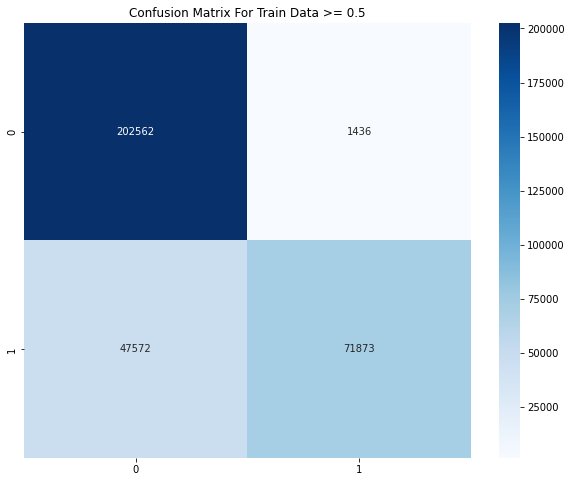

In [26]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_train , y_train_pred1), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Train Data >= 0.5")
plt.show()

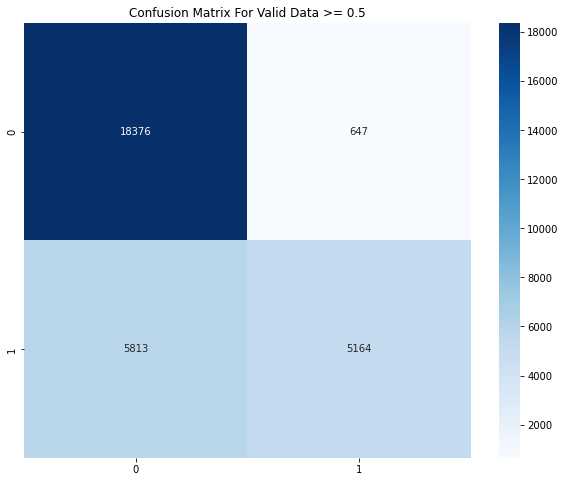

In [27]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_valid , y_valid_pred1), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Valid Data >= 0.5")
plt.show()

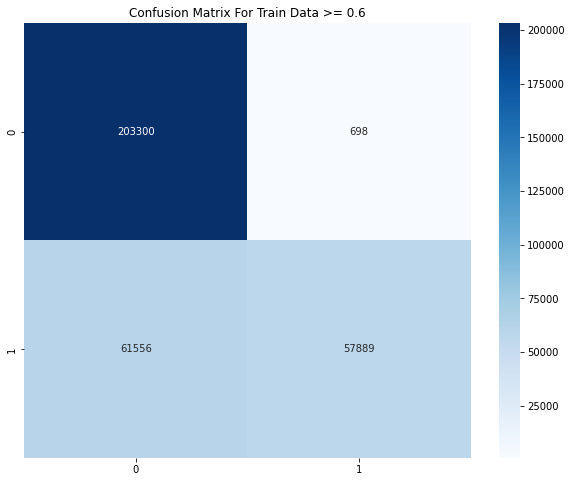

In [28]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_train , y_train_pred2), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Train Data >= 0.6")
plt.show()

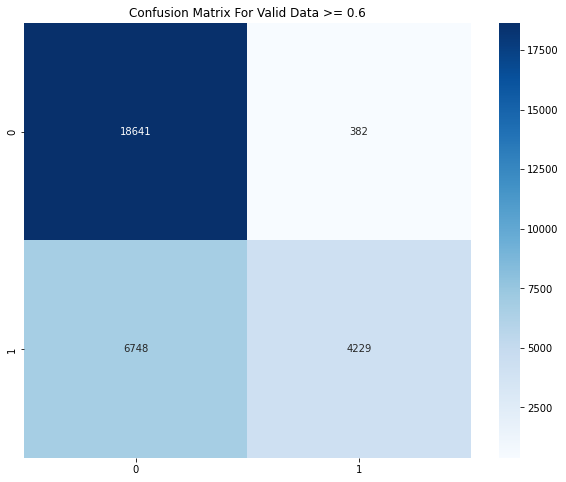

In [38]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_valid , y_valid_pred2), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Valid Data >= 0.6")
plt.show()

So, This's obvious that the more we increased the threshold even by 0.1 the more we get rid of **False Positive** but that would increase the False Negative as well which cause the **Recall** to drop and our model would just predict only few points as Positive, but our ratio here is resonable as we want our model not to declare any not duplicate pairs as duplicate even if we have to sacrfice the **Recall** here.

Something to mention here that our model suffer from uncertinty and that belong the high loss in comparing to **Precision** Score, which means that the model is making a big miskate on small amount of data like predicting positive data point with probability of 0.6 which yield 1 rather than 0.9.

# Evaluating DL Model on Test Data

In [30]:
model.evaluate(x_test, y_test)

1590/1590 [==============================] - 9s 6ms/step - loss: 0.4554 - accuracy: 0.7815 - precision: 0.8949


[0.4553895890712738, 0.7814736366271973, 0.8948759436607361]

**Test Data:**

Log Loss: 0.4554

accuracy: 78.15%

Precision: 89.49

In [33]:
y_test_pred = model.predict(x_test)

In [34]:
y_test_pred1 = (y_test_pred >= 0.5)

y_test_pred2 = (y_test_pred >= 0.6)

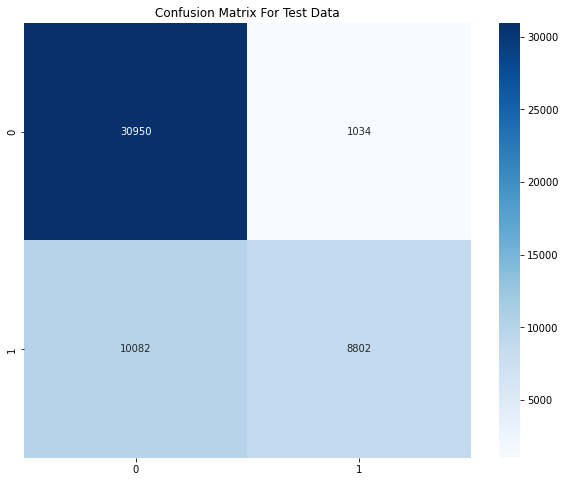

In [35]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_test , y_test_pred1), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Test Data")
plt.show()

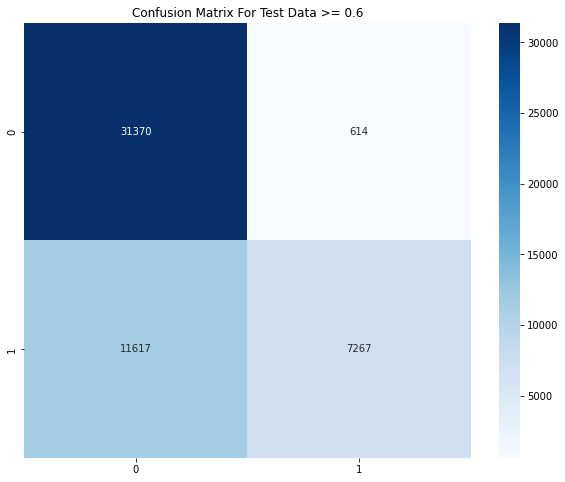

In [36]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_test , y_test_pred2), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Test Data >= 0.6")
plt.show()

# Further Imporvments

1.   Try In-Depth more features related to questions statistics in Quora DataBase.

2.   Use diffrent Word to Vectors algorithm to process questions and to design vectors out of words and phrases.

3. Try another ML algorithm for example Stacking or RF or another GBDT package like LightGBM or XGBoost.